# Analysis

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
sns.set()
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
J_DAYS = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
CITIES = ['מודיעין מכבים רעות', 'באר שבע', 'נתניה']
MODIIN,BEERSHEVA,NETANIA = CITIES

In [2]:
#full_df = pd.read_pickle('full.pkl')
full_hour_df = pd.read_pickle('hour.pkl')
full_day_df = pd.read_pickle('day.pkl')
id_df = pd.read_pickle('id.pkl')

In [3]:
full_hour_df.head(1)

total         id  count_reg                city  month  day  weekday  \
0  199.341003  702552276         11  מודיעין מכבים רעות      1    1        5   

  weekday_name  day_of_year  week  year  hour  consumption         ts  \
0     Saturday            1    52  2022     0        5.037 2022-01-01   

   temperature  r_humidity  heat_index  
0    10.716666        79.5   10.716667

In [4]:
full_day_df = full_day_df.rename(columns={'total':'consumption'})
full_day_df.head(1)

id  count_reg                city  month  day  weekday weekday_name  \
0  702552276         11  מודיעין מכבים רעות      1    1        5     Saturday   

   day_of_year  week  year  consumption  temperature  r_humidity  heat_index  \
0            1    52  2022   199.341003     9.863194   84.395836    9.863194   

          ts  
0 2022-01-01

In [5]:
id_df.head(1)

count_reg  no.                city  city_code_HHI  city_code_LAMAS  \
id                                                                              
702552276         11   32  מודיעין מכבים רעות           1932             1200   

          street                      address        lat        lng  
id                                                                   
702552276  חרצית  חרצית 32 מודיעין מכבים רעות  31.905869  35.010933

In [6]:
daily_usage = full_day_df[full_day_df.year == 2022][['id', 'consumption']].groupby('id').mean().reset_index()
bad_buildings = set(full_day_df[(np.log10(full_day_df.consumption + 1) > 4.5) | (full_day_df.count_reg > 30)].id.unique())
bad_buildings = bad_buildings.union(set(daily_usage[(daily_usage.consumption < 50) | (daily_usage.consumption > 1000)].id.values))
bad_buildings = bad_buildings.union({702553250, 702562180, 704195954, 704200336})

In [7]:
modiin_df = pd.read_csv('./raw_data/modiin_data_clean.csv')
valid_ids = set(modiin_df.building_number.unique())
bad_buildings2 = {x[0] for x in full_day_df[['id', 'city']].values if x[1] == MODIIN and x[0] not in valid_ids}
bad_buildings = bad_buildings.union(bad_buildings2)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_20912\1168776408.py:1: DtypeWarning: Columns (1,12,13,14,15,16,17,18,19,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107) have mixed types. Specify dtype option on import or set low_memory=False.
  modiin_df = pd.read_csv('./raw_data/modiin_data_clean.csv')


In [8]:
len(valid_ids)

2510

In [9]:
day_df = pd.DataFrame(full_day_df[(full_day_df.id.map(lambda x: x not in bad_buildings)) & (full_day_df.year == 2022)])
hour_df = pd.DataFrame(full_hour_df[(full_hour_df.id.map(lambda x: x not in bad_buildings)) & (full_hour_df.year == 2022)])

In [10]:
id_df[['city']].value_counts()

city              
מודיעין מכבים רעות    2601
נתניה                 1200
באר שבע               1076
dtype: int64

In [11]:
day_df[['id', 'city']].groupby(['id', 'city']).count().reset_index()[['city']].value_counts()

city              
מודיעין מכבים רעות    2385
נתניה                  412
באר שבע                340
dtype: int64

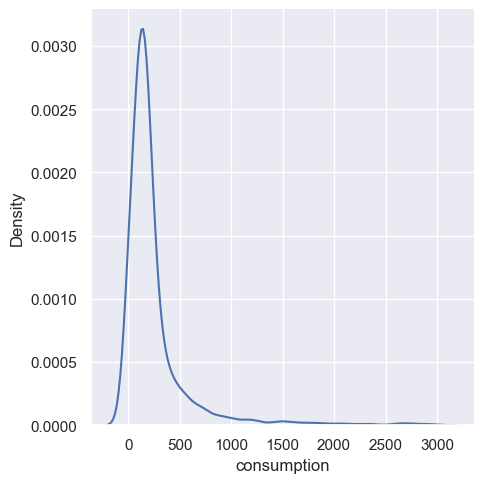

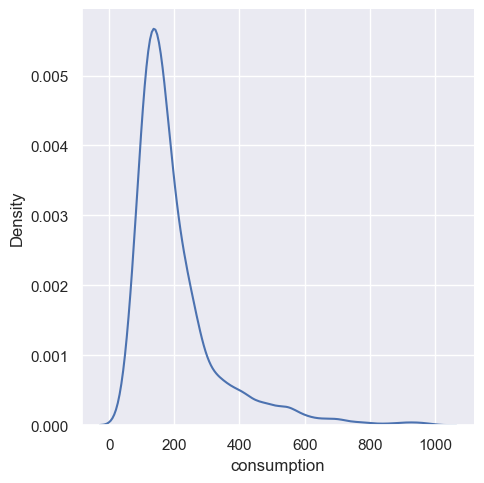

In [13]:
sns.displot(daily_usage[(daily_usage.consumption < 3000)].consumption, kind='kde')
sns.displot(daily_usage[daily_usage.id.map(lambda x: x not in bad_buildings)].consumption, kind='kde')

# Basic viz

In [18]:
def radar_plt(stats, ax, title, labels=None):
    if labels is None:
        labels = np.arange(1, len(stats)+1)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)[::-1] # Set the angle
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, np.concatenate((labels, labels[:1])))  # Set the label for each axis
    ax.set_title(title)  # Set the pokemon's name as the title
    #ax.set_rlim(0,250)
    ax.grid(True)

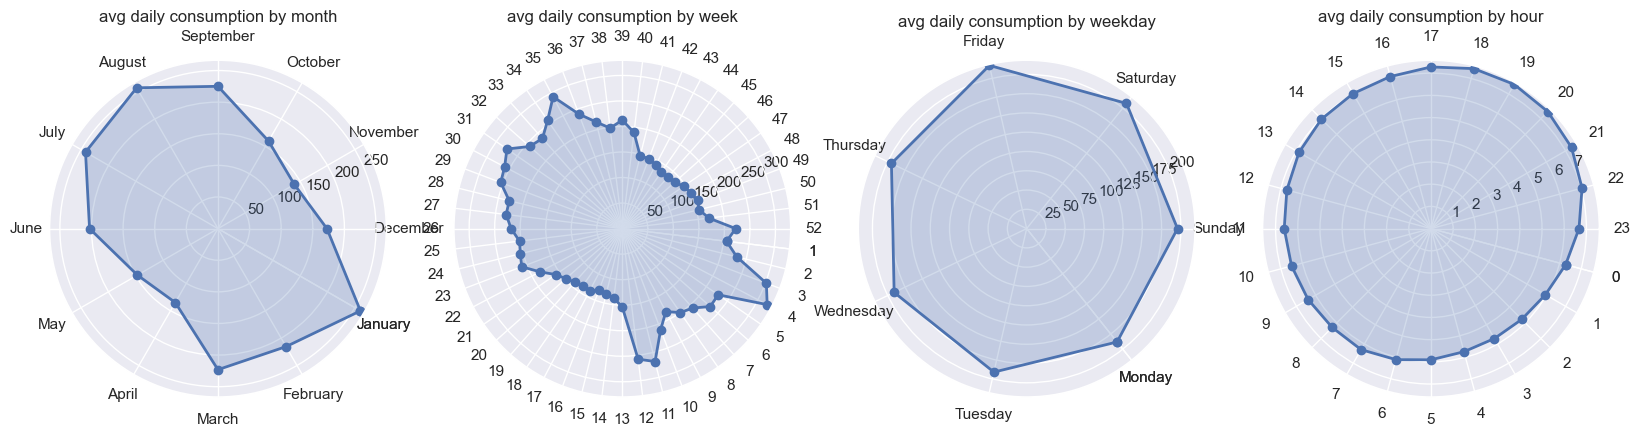

In [19]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='polar'))
stats=day_df.groupby('month').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[0], 'avg daily consumption by month', MONTHS)
stats=day_df.groupby('week').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[1], 'avg daily consumption by week')
stats=day_df.groupby('weekday').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[2], 'avg daily consumption by weekday', DAYS)
stats=hour_df.groupby('hour').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[3], 'avg daily consumption by hour', np.arange(0,24))

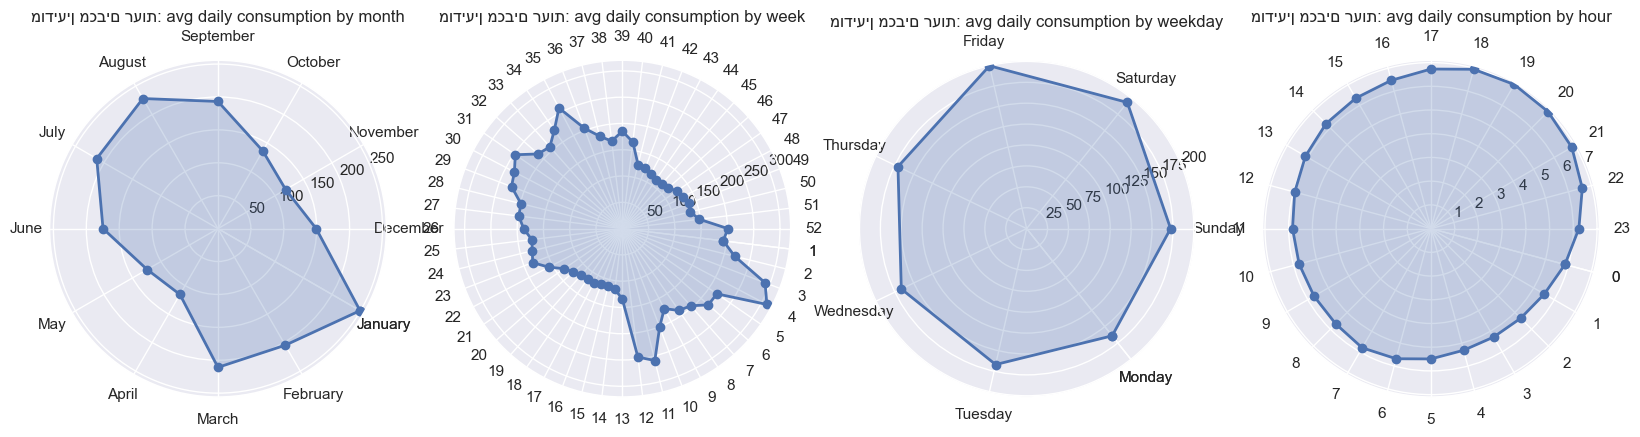

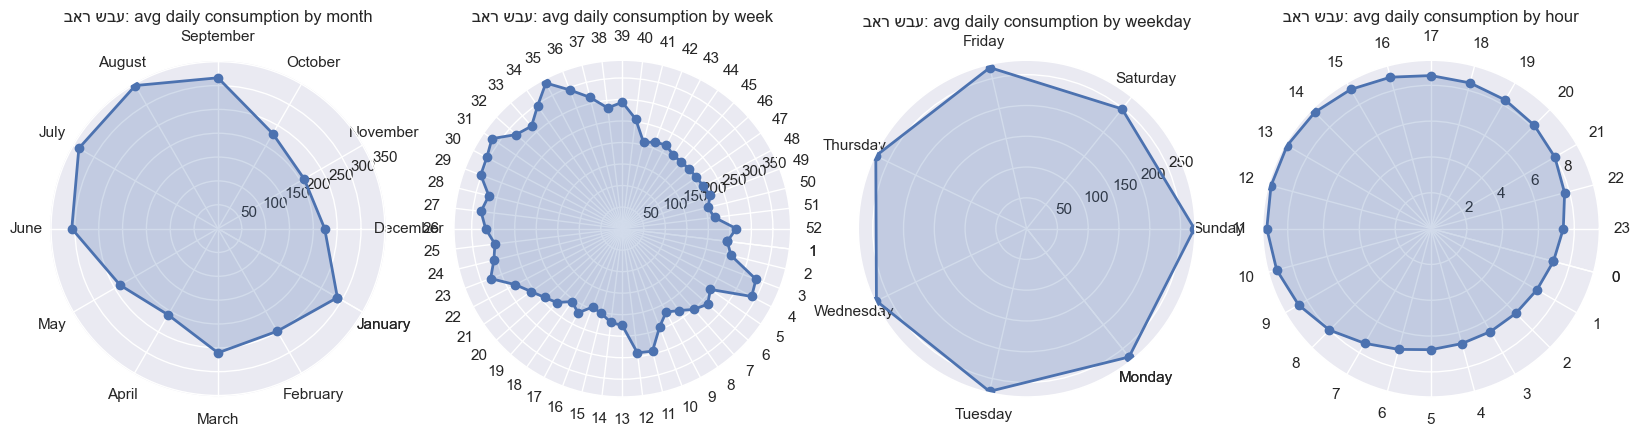

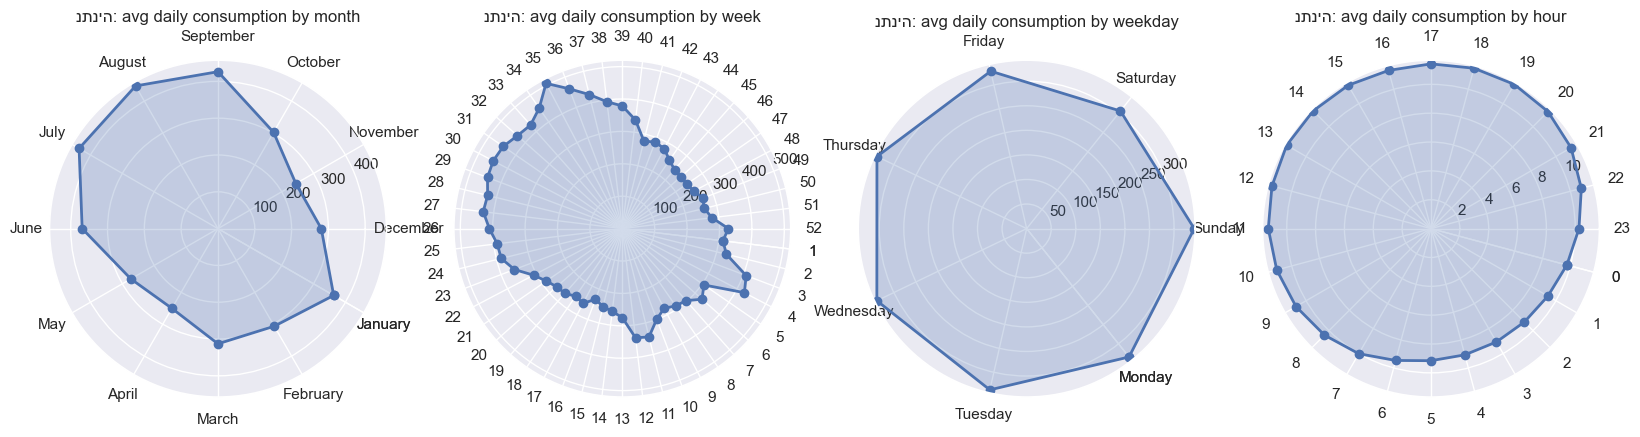

In [20]:
for city in CITIES:
    fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=4,
                                subplot_kw=dict(projection='polar'))
    stats=day_df[day_df.city == city].groupby('month').mean(numeric_only=True).consumption.values
    radar_plt(stats, axs[0], f'{city}: avg daily consumption by month', MONTHS)
    stats=day_df[day_df.city == city].groupby('week').mean(numeric_only=True).consumption.values
    radar_plt(stats, axs[1], f'{city}: avg daily consumption by week')
    stats=day_df[day_df.city == city].groupby('weekday').mean(numeric_only=True).consumption.values
    radar_plt(stats, axs[2], f'{city}: avg daily consumption by weekday', DAYS)
    stats=hour_df[hour_df.city == city].groupby('hour').mean(numeric_only=True).consumption.values
    radar_plt(stats, axs[3], f'{city}: avg daily consumption by hour', np.arange(0,24))

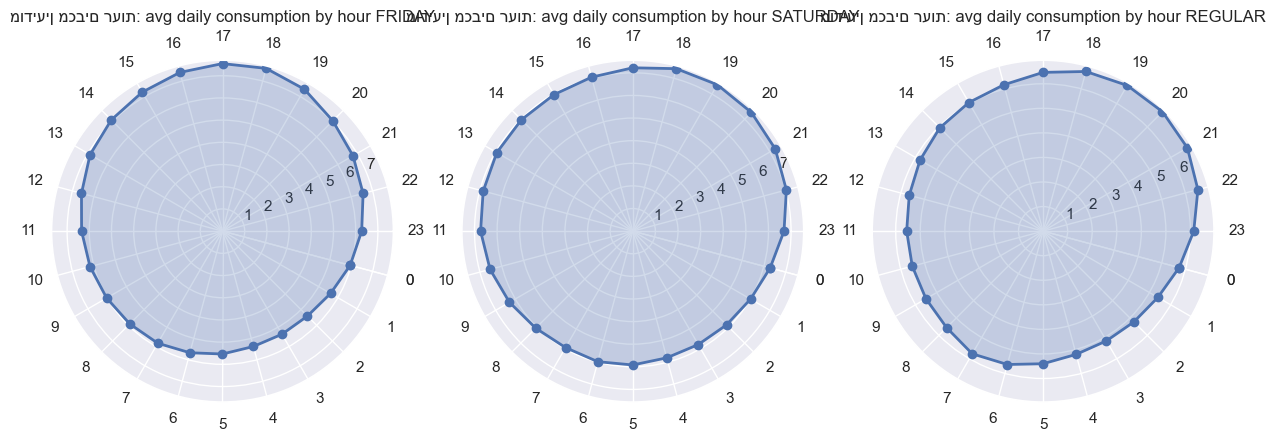

In [21]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, subplot_kw=dict(projection='polar'))
city = MODIIN
stats=hour_df[(hour_df.city == city) & (hour_df.weekday == 4)].groupby('hour').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[0], f'{city}: avg daily consumption by hour FRIDAY', np.arange(0,24))
stats=hour_df[(hour_df.city == city) & (hour_df.weekday == 5)].groupby('hour').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[1], f'{city}: avg daily consumption by hour SATURDAY', np.arange(0,24))
stats=hour_df[(hour_df.city == city) & (hour_df.weekday != 4) & (hour_df.weekday != 5)].groupby('hour').mean(numeric_only=True).consumption.values
radar_plt(stats, axs[2], f'{city}: avg daily consumption by hour REGULAR', np.arange(0,24))

[Text(0.5, 1.0, 'consumption')]

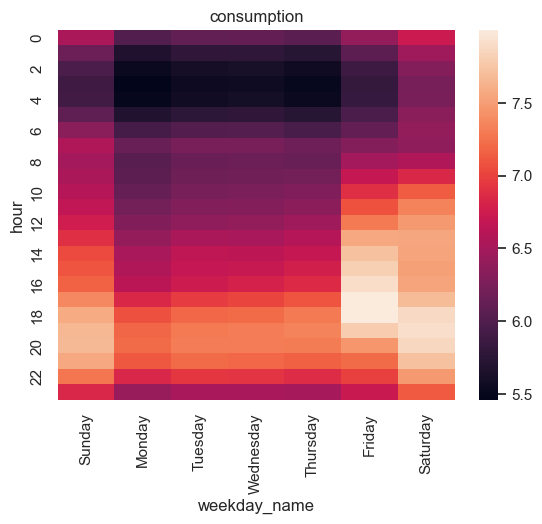

In [22]:
table = hour_df.groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption')
sns.heatmap(table).set(title='consumption')

[Text(0.5, 1.0, 'MODIIN consumption')]

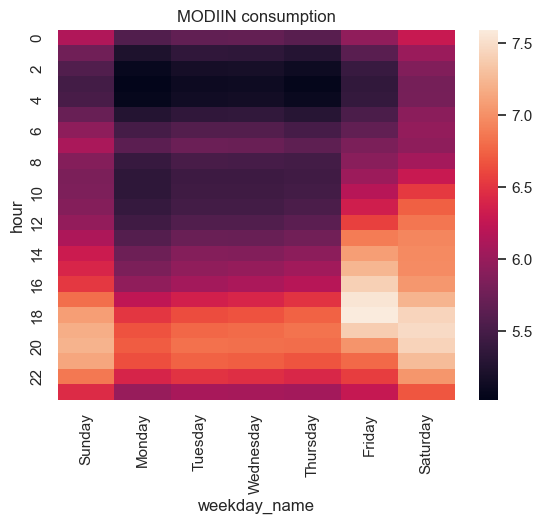

In [23]:
table = hour_df[hour_df.city == MODIIN].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption')
sns.heatmap(table).set(title='MODIIN consumption')

[Text(0.5, 1.0, 'consumption')]

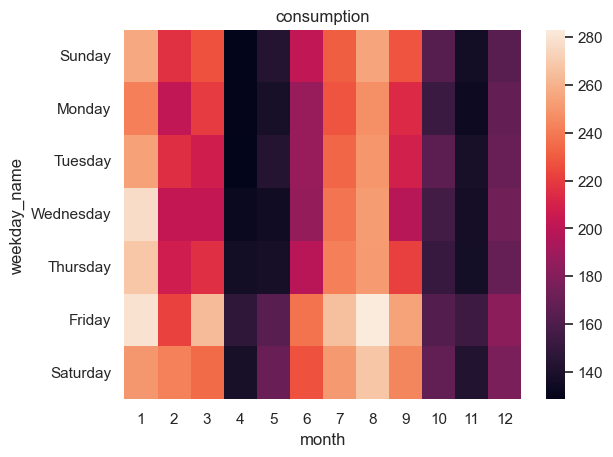

In [24]:
table = day_df.groupby(['weekday_name', 'month']).mean(numeric_only=True)['consumption'].reset_index().pivot(columns='month', index='weekday_name', values='consumption')
sns.heatmap(table).set(title='consumption')

<Axes: xlabel='rounded_heat_index', ylabel='consumption'>

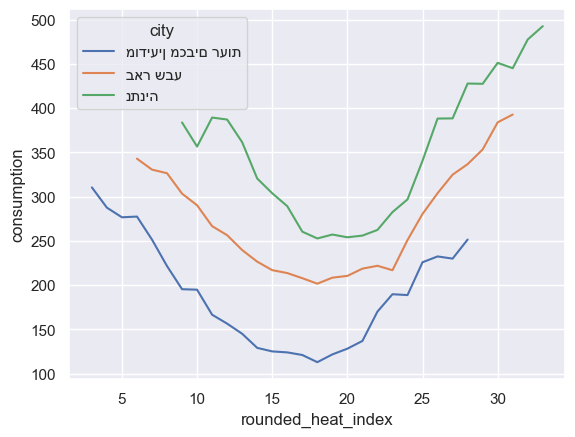

In [25]:
day_df['rounded_heat_index'] = day_df.heat_index.round(0)
sns.lineplot(data=day_df, x='rounded_heat_index', y='consumption', hue='city', errorbar=None)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_20912\2888325458.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr_df = day_df.groupby(['id', 'city']).mean()


<Axes: xlabel='count_reg', ylabel='consumption'>

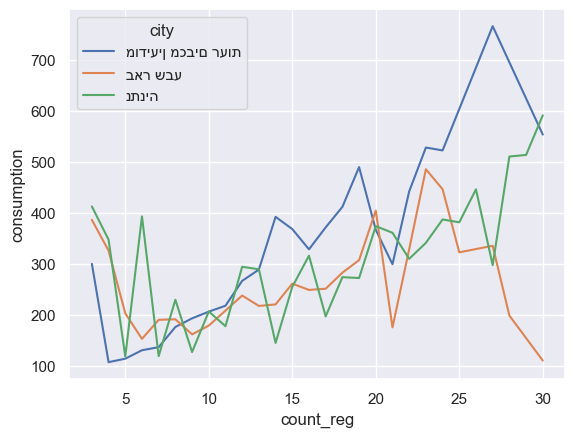

In [26]:
gr_df = day_df.groupby(['id', 'city']).mean()
sns.lineplot(data=gr_df, x='count_reg', y='consumption', hue='city', errorbar=None)

<Axes: xlabel='count_reg', ylabel='consumption'>

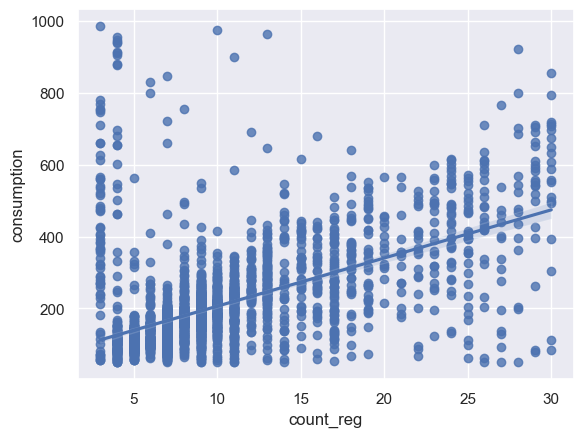

In [27]:
sns.regplot(data=gr_df, x='count_reg', y='consumption')

# heatmap

In [11]:
from collections import defaultdict
h_df = pd.DataFrame(hour_df[(hour_df.city == MODIIN)][['id', 'ts','hour', 'consumption', 'heat_index', 'count_reg']])
day_mapping = {i: 'regular' for i in range(7)}
day_mapping[4] = 'friday'
day_mapping[5] = 'saturday'
h_df['day_type'] = hour_df.weekday.map(lambda x: day_mapping[x])
h_df.head(1)

id         ts  hour  consumption  heat_index  count_reg  day_type
0  702552276 2022-01-01     0        5.037   10.716667         11  saturday

In [12]:
w_df = pd.read_pickle('weather.pkl').reset_index(drop=True)
w_df = w_df[w_df.ts.dt.year == 2022]
w_df = w_df.groupby(w_df.ts.dt.day_of_year).mean()
w_df.head(1)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_20028\5952331.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  w_df = w_df.groupby(w_df.ts.dt.day_of_year).mean()


temperature  r_humidity  heat_index
ts                                     
1     12.854167   79.930556   12.854167

In [37]:
%%time
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_
agg_dict = h_df[['id', 'day_type', 'hour', 'consumption']].groupby(['id', 'day_type', 'hour']).agg(
    mean_consumption=('consumption', np.mean), 
    q_consumption=('consumption', percentile(0.2))).to_dict()

results = []
for x in h_df[['id', 'day_type', 'hour', 'consumption']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[3] - agg_dict[name][x[0], x[1], x[2]])/agg_dict[name][x[0], x[1], x[2]])
    results.append(row)
h_df[['diff_consumption_day_hour', 'diff_q_consumption_day_hour']] = results
h_df.head(1)

CPU times: total: 1min 22s
Wall time: 1min 22s


id         ts  hour  consumption  heat_index  count_reg  day_type  \
0  702552276 2022-01-01     0        5.037   10.716667         11  saturday   

   diff_consumption_day_hour  diff_q_consumption_day_hour  
0                 -24.892814                     22.65621

In [38]:
%%time
agg_dict = h_df[['id','consumption']].groupby(['id']).agg(
    mean_consumption=('consumption', np.mean), 
    q_consumption=('consumption', percentile(0.2))).to_dict()
results = []
for x in h_df[['id', 'consumption']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[1] - agg_dict[name][x[0]])/agg_dict[name][x[0]])
    results.append(row)
h_df[['diff_consumption', 'diff_q_consumption']] = results
h_df.head(1)

CPU times: total: 35.4 s
Wall time: 35.4 s


id         ts  hour  consumption  heat_index  count_reg  day_type  \
0  702552276 2022-01-01     0        5.037   10.716667         11  saturday   

   diff_consumption_day_hour  diff_q_consumption_day_hour  diff_consumption  \
0                 -24.892814                     22.65621        -14.928874   

   diff_q_consumption  
0           51.945688

In [39]:
h_df['half_increase'] = (h_df.diff_q_consumption_day_hour > 50)
h_df['double_increase'] = (h_df.diff_q_consumption_day_hour > 100)

area_df = pd.read_csv('./raw_data/modiin_join_flr_area.csv')
area_mapping = {x[2]: x[-1] for x in area_df.values}
h_df['area'] = [area_mapping.get(x,1) for x in h_df.id.values]
h_df['sqm_consumption'] = h_df.consumption / h_df.area

h_df.head(1)

id         ts  hour  consumption  heat_index  count_reg  day_type  \
0  702552276 2022-01-01     0        5.037   10.716667         11  saturday   

   diff_consumption_day_hour  diff_q_consumption_day_hour  diff_consumption  \
0                 -24.892814                     22.65621        -14.928874   

   diff_q_consumption  r_heat_index  half_increase  double_increase      area  \
0           51.945688            11          False            False  12027.25   

   sqm_consumption  
0         0.000419

In [44]:
h_df[[x for x in h_df.columns if x != 'r_heat_index']].to_csv('hour_data.csv', index=False)

In [106]:
full_h_df = pd.DataFrame(h_df)
h_df['r_heat_index'] = np.round(h_df.heat_index).astype('int')
h_df = pd.DataFrame(h_df[(h_df.ts.dt.month >= 4) & (h_df.ts.dt.month <= 9) & (h_df.area != 1)])

[Text(0.5, 1.0, 'MODIIN regular days. Mean consumption change (w.r.t. 20th quantile for this building/day type/hour)')]

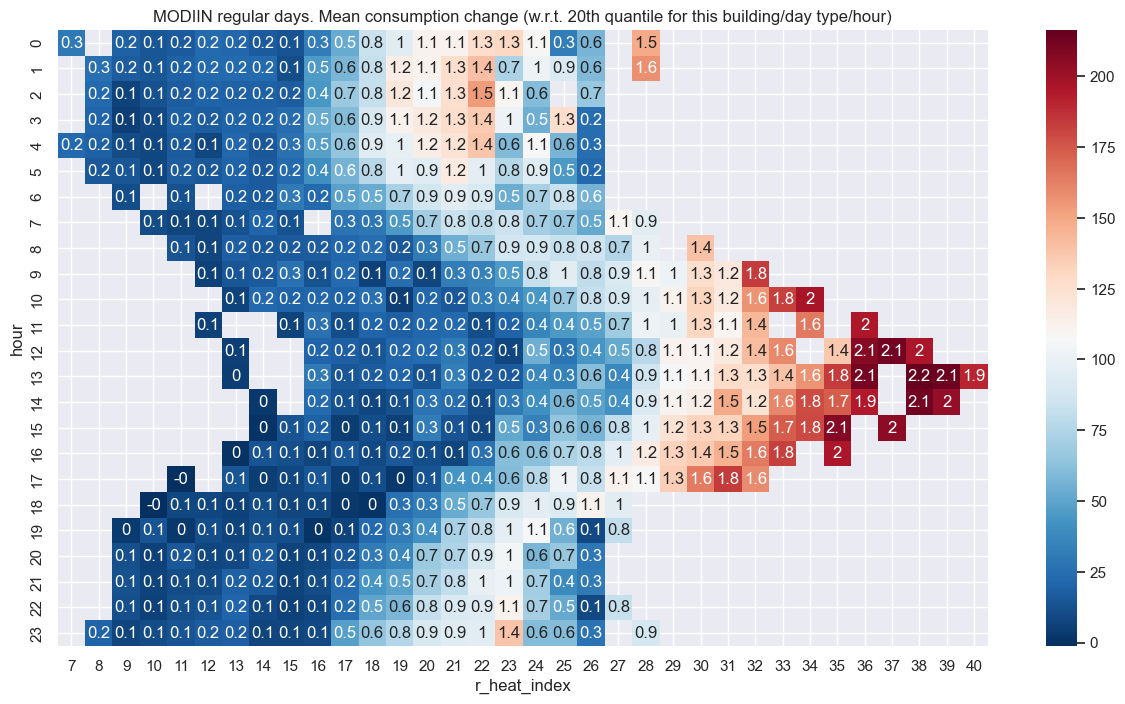

In [107]:
#gr = h_df[['day_type', 'hour', 'consumption', 'temperature', 'n_consumption']].groupby(['day_type', 'hour', 'consumption'
#for day_type in ['regular', 'friday', 'saturday'][:1]:
tmp = h_df[['hour', 'diff_q_consumption_day_hour', 'r_heat_index', 'count_reg']]
table = tmp.groupby(['r_heat_index', 'hour']).mean().reset_index().pivot(columns='r_heat_index', index='hour', values='diff_q_consumption_day_hour')
plt.figure(figsize=(15,8))
sns.heatmap(table, annot=np.round(table.values/100, 1), cmap='RdBu_r').set(title=f'MODIIN {day_type} days. Mean consumption change (w.r.t. 20th quantile for this building/day type/hour)')

[Text(0.5, 1.0, 'MODIIN regular days. % of homes consuming twice than usual')]

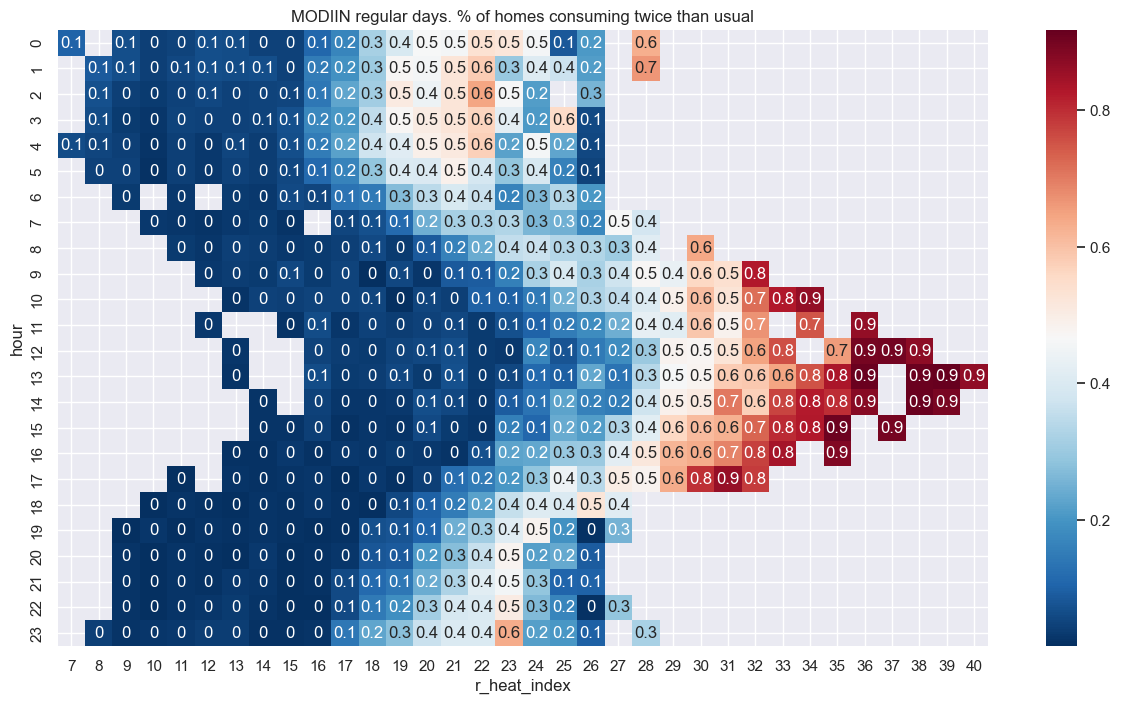

In [108]:
#gr = h_df[['day_type', 'hour', 'consumption', 'temperature', 'n_consumption']].groupby(['day_type', 'hour', 'consumption'
#for day_type in ['regular', 'friday', 'saturday'][:1]:
tmp = h_df[['hour', 'double_consumption', 'r_heat_index', 'count_reg']]
table = tmp.groupby(['r_heat_index', 'hour']).mean().reset_index().pivot(columns='r_heat_index', index='hour', values='double_consumption')
plt.figure(figsize=(15,8))
sns.heatmap(table, annot=np.round(table.values, 1), cmap='RdBu_r').set(title=f'MODIIN {day_type} days. % of homes consuming twice than usual')

In [109]:
gr = h_df.groupby(['ts', 'day_type', 'hour']).mean().reset_index()
d = w_df.to_dict()['heat_index']
temps = np.array([d[i] for i in range(1,366)])
gr['mean_hi'] = gr.ts.map(lambda x: temps[x.day_of_year - 1])
h_df['mean_hi'] = h_df.ts.map(lambda x: temps[x.day_of_year - 1])
for ws in [3,5,7,10]:
    mean_temps = [temps[0]] + [temps[max(0, i-ws):i].mean() for i in range(1, len(temps))]
    gr[f'{ws}ma_hi'] = gr.ts.map(lambda x: mean_temps[x.day_of_year - 1])
    h_df[f'{ws}ma_hi'] = h_df.ts.map(lambda x: mean_temps[x.day_of_year - 1])

gr.head(1)

ts day_type  hour            id  consumption  heat_index  count_reg  \
0 2022-04-01   friday     0  7.025956e+08     4.833998   20.316667   8.523601   

   consumption_diff_day_hour  q_consumption_diff_day_hour  \
0                 -23.495864                    36.102676   

   consumption_diff_id  r_heat_index  more_than_usual  double_consumption  \
0           -25.145012          20.0         0.287591            0.115815   

     mean_hi     3ma_hi     5ma_hi     7ma_hi    10ma_hi  
0  21.292268  16.871066  15.185556  13.931746  12.497153

<Axes: xlabel='ts', ylabel='heat_index'>

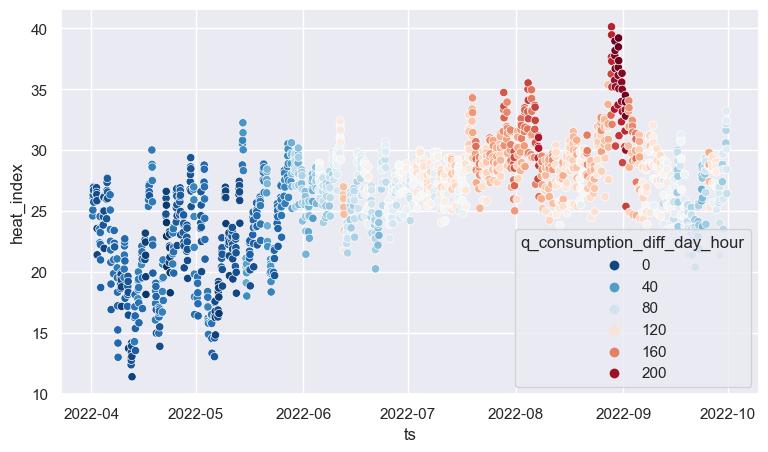

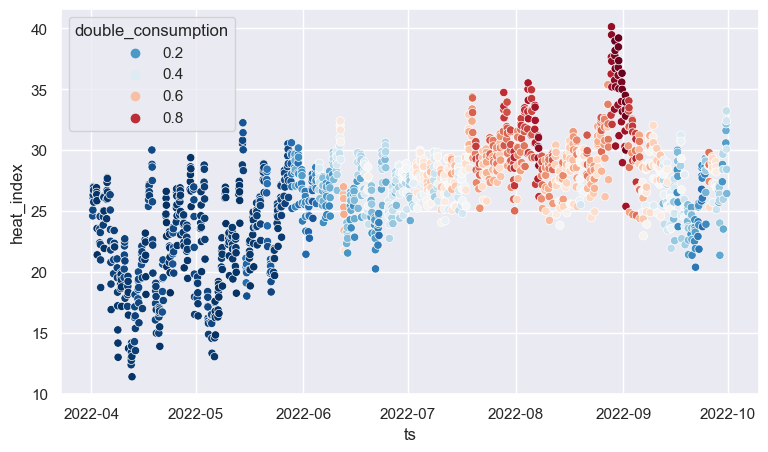

In [110]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 18)], x='ts', y='heat_index', hue='diff_q_consumption_day_hour', palette='RdBu_r')
plt.figure(figsize=(9,5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 18)], x='ts', y='heat_index', hue='double_consumption', palette='RdBu_r')

<Axes: xlabel='3ma_hi', ylabel='heat_index'>

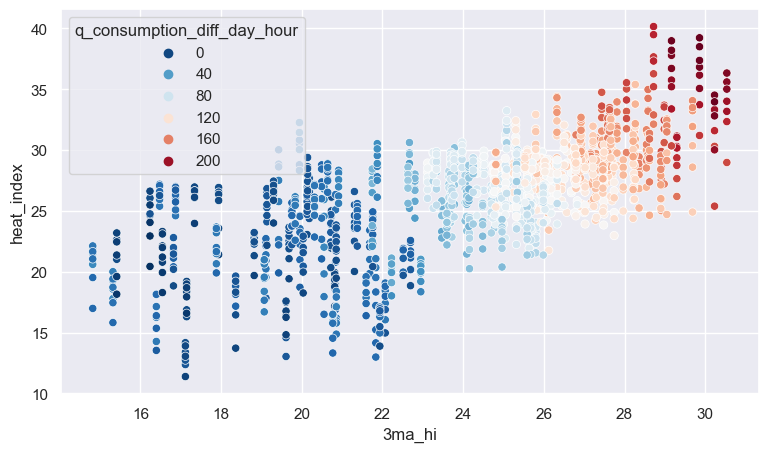

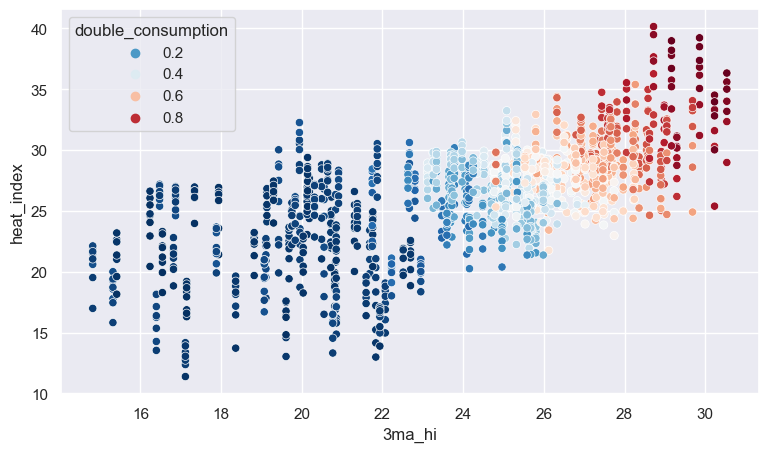

In [111]:
plt.figure(figsize=(9, 5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 18)], x='3ma_hi', y='heat_index', hue='diff_q_consumption_day_hour', palette='RdBu_r')
plt.figure(figsize=(9, 5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 18)], x='3ma_hi', y='heat_index', hue='double_consumption', palette='RdBu_r')

In [112]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
CUTOFF = 20
data = h_df[(h_df.hour > 11) & (h_df.hour < 17)][['heat_index', '5ma_hi', '3ma_hi', '7ma_hi', 'diff_q_consumption_day_hour', 'more_than_usual', 'double_consumption', 'consumption_diff_id', 'ts']]
data['shifted_hi'] = np.clip(data.heat_index - CUTOFF, 0, None)
data['shifted_5ma_hi'] = np.clip(data['5ma_hi'] - CUTOFF, 0, None)
data['shifted_3ma_hi'] = np.clip(data['3ma_hi'] - CUTOFF, 0, None)
data['shifted_7ma_hi'] = np.clip(data['7ma_hi'] - CUTOFF, 0, None)
data.head(1)

heat_index     5ma_hi     3ma_hi     7ma_hi  \
20219692   26.111858  15.185556  16.871066  13.931746   

          q_consumption_diff_day_hour  more_than_usual  double_consumption  \
20219692                           19            False               False   

          consumption_diff_id                  ts  shifted_hi  shifted_5ma_hi  \
20219692                  -14 2022-04-01 12:00:00    6.111858             0.0   

          shifted_3ma_hi  shifted_7ma_hi  
20219692             0.0             0.0

Feature importance: HEAT_INDEX - 2.9612965402459306, 3DAY_AVG - 15.553214818776546.
R coef: 0.24083501458341317
MSE: 9628.54204833457


Text(0.5, 1.0, 'Real (red) vs predicted (blue) consumption change between 11 and 16')

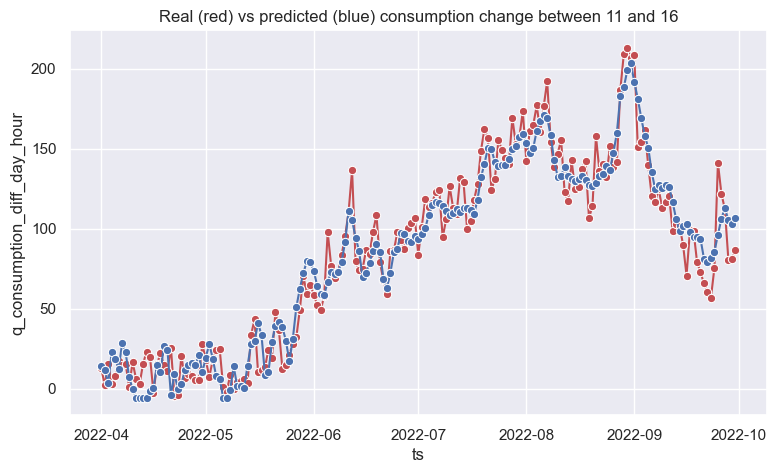

In [113]:
y = data.diff_q_consumption_day_hour
X = data[['shifted_hi', 'shifted_3ma_hi']]
regr = linear_model.LinearRegression()
regr.fit(X, y)
preds = regr.predict(X)
data['preds'] = preds
print(f'Feature importance: HEAT_INDEX - {regr.coef_[0]}, 3DAY_AVG - {regr.coef_[1]}.')
print(f'R coef: {regr.score(X, y)}')
print(f'MSE: {mean_squared_error(y, preds)}')
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr, x='ts', y='diff_q_consumption_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr, x='ts', y='preds', color='b', marker='o')
f.set_title('Real (red) vs predicted (blue) consumption change between 11 and 16')

Text(0.5, 1.0, 'Real (blue) vs predicted (red) consumption change between 11 and 16 when trained till 1.08')

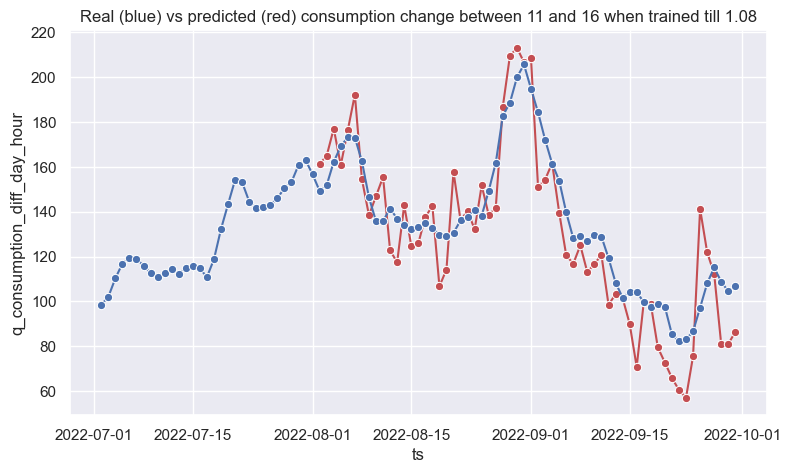

In [114]:
y = data[data.ts < pd.Timestamp('2022-08-01')].diff_q_consumption_day_hour
X = data[data.ts < pd.Timestamp('2022-08-01')][['shifted_hi', 'shifted_3ma_hi']]
regr = linear_model.LinearRegression()
regr.fit(X, y)
data['preds'] = regr.predict(data[['shifted_hi', 'shifted_3ma_hi']])
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-08-01')], x='ts', y='diff_q_consumption_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-07-01')], x='ts', y='preds', color='b', marker='o')
f.set_title('Real (blue) vs predicted (red) consumption change between 11 and 16 when trained till 1.08')

In [115]:
h_df.head(1)

id         ts  hour  consumption  heat_index  count_reg day_type  \
88  702552276 2022-04-01     0         3.54   20.316667         11   friday   

    consumption_diff_day_hour  q_consumption_diff_day_hour  \
88                        -40                            5   

    consumption_diff_id  r_heat_index  more_than_usual  double_consumption  \
88                  -40            20            False               False   

      mean_hi     3ma_hi     5ma_hi     7ma_hi    10ma_hi  
88  21.292268  16.871066  15.185556  13.931746  12.497153

Text(0.5, 1.0, 'Effect of heat index and moving average on the q_consumption_diff_day_hour between 12 and 16')

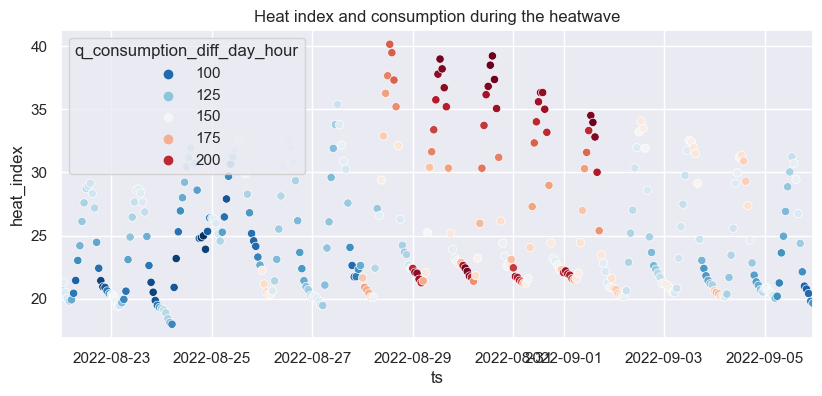

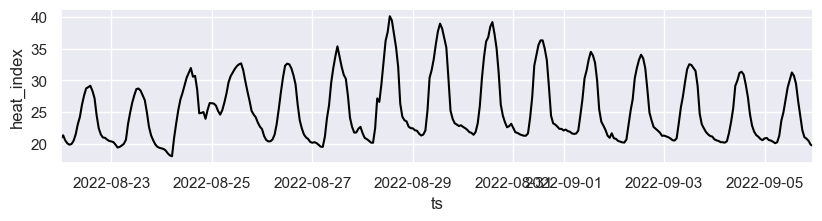

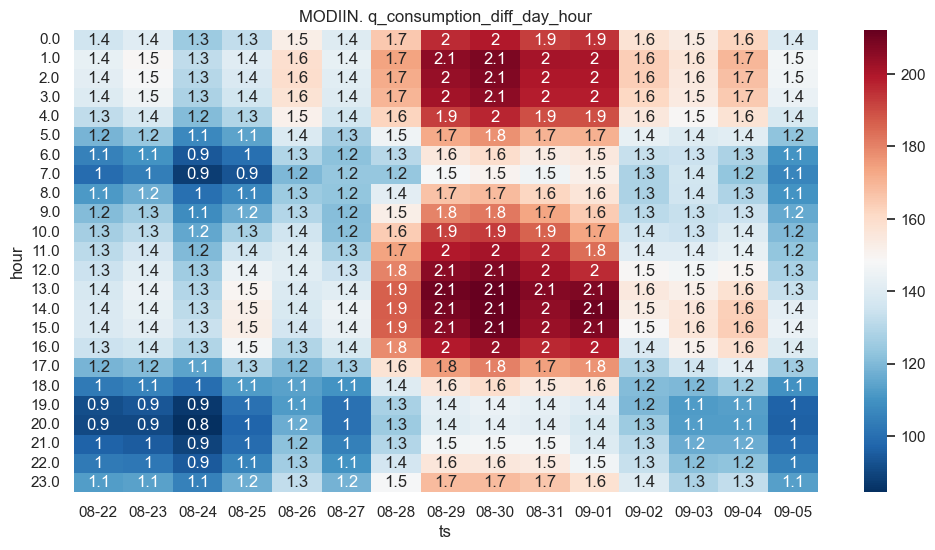

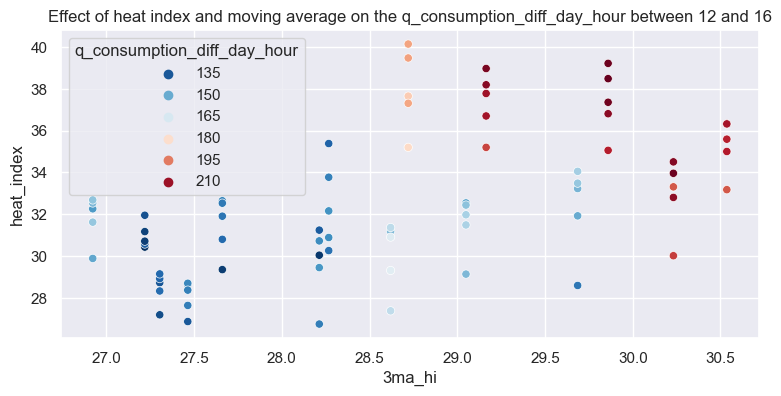

In [116]:
metric = 'diff_q_consumption_day_hour'
#for doy in [107, 161, 216, 241][2:3]:
doy = 241
df = h_df[np.abs(h_df.ts.dt.day_of_year - doy) <= 7]
gr = df.groupby('ts').mean(numeric_only=True).reset_index()

plt.figure(figsize=(9.7,4))
f = sns.scatterplot(data=gr[(gr.hour >= 0) & (gr.hour < 27)], x='ts', y='heat_index', hue=metric, palette='RdBu_r')
f.set_title(f'Heat index and consumption during the heatwave')
f.set_xlim(df.ts.min(), df.ts.max())

plt.figure(figsize=(9.7,2))
f = sns.lineplot(x='ts', y='heat_index', data=gr, color='black')
f.set_xlim(df.ts.min(), df.ts.max())

def weighted_average(df, values, weights):
    return sum(df[weights] * df[values]) / df[weights].sum()
tmp = df[['hour', metric, 'ts', 'count_reg']]
table = tmp.groupby('ts').mean().reset_index()
table['weighed_average'] =tmp.groupby('ts').apply(weighted_average, metric, 'count_reg').reset_index()[0]
table['ts'] = table.ts.dt.floor('D')
table = table.pivot(columns='ts', index='hour', values='weighed_average')
plt.figure(figsize=(12,6))
sns.heatmap(table, annot=np.round(table.values/100,1) if metric == 'diff_q_consumption_day_hour' else np.round(table.values, 1), cmap='RdBu_r', xticklabels=[x.strftime('%m-%d') for x in table.columns]).set(title=f'MODIIN. {metric}')

plt.figure(figsize=(9,4))
f = sns.scatterplot(data=gr[(gr.hour >= 12) & (gr.hour < 17)], x='3ma_hi', y='heat_index', hue=metric, palette='RdBu_r')
f.set_title(f'Effect of heat index and moving average on the {metric} between 12 and 16')


2565

# Or's request

In [31]:
#doi = 240-242 #160-162
#241 161 +-1

<Axes: xlabel='ts', ylabel='heat_index'>

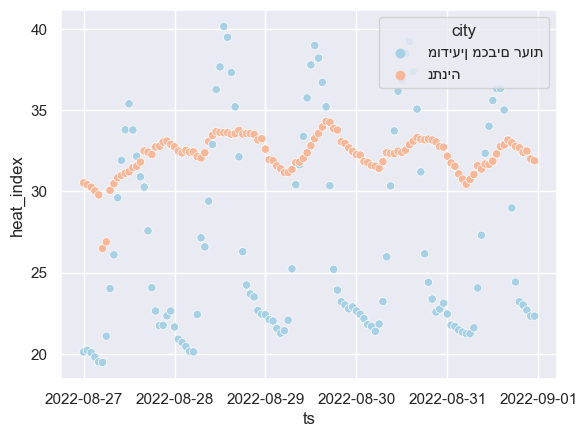

In [267]:
df = h_df[np.abs(h_df.ts.dt.day_of_year - 241) <= 2]
gr = df.groupby(['ts', 'city']).mean(numeric_only=True).reset_index()
sns.scatterplot(data=gr[(gr.hour >= 0) & (gr.hour < 27)], x='ts', y='heat_index', hue='city', palette='RdBu_r')

In [55]:
d_df = pd.DataFrame(day_df[(day_df.ts.dt.month >= 4) & (day_df.ts.dt.month <= 9)][['id', 'city', 'ts', 'consumption', 'heat_index', 'count_reg']])
day_mapping = {i: 'regular' for i in range(7)}
day_mapping[4] = 'friday'
day_mapping[5] = 'saturday'
d_df['day_type'] = d_df.ts.dt.weekday.map(lambda x: day_mapping[x])
d_df.head(1)

id                city         ts  consumption  heat_index  \
137  702552276  מודיעין מכבים רעות 2022-04-01   133.419006   23.404108   

     count_reg day_type  
137         11   friday

In [56]:
means = (d_df[['id', 'consumption']].groupby('id').mean()).to_dict()['consumption']

In [57]:
def filt(df):
    gr = df.groupby('id').count().reset_index()
    bad_ids = gr[gr.consumption < gr.consumption.max()].id.values
    df = df[df.id.map(lambda x: x not in bad_ids)]
    return df

In [58]:
doy = 161
tmp_df = d_df[(d_df.ts.dt.day_of_year < doy-1) & (d_df.ts.dt.day_of_year >= doy-8) & (d_df.day_type == 'regular')]
tmp_df = filt(tmp_df)
means_june = (tmp_df[['id', 'consumption']].groupby('id').mean()).to_dict()['consumption']

tmp_df = d_df[(d_df.ts.dt.day_of_year - doy >= -1) & (d_df.ts.dt.day_of_year - doy <= 1)]
tmp_df = filt(tmp_df)
means_june_hw = (tmp_df[['id', 'consumption']].groupby('id').mean()).to_dict()['consumption']

In [59]:
doy = 241
tmp_df = d_df[(d_df.ts.dt.day_of_year < doy-1) & (d_df.ts.dt.day_of_year >= doy-8) & (d_df.day_type == 'regular')]
tmp_df = filt(tmp_df)
means_aug = (tmp_df[['id', 'consumption']].groupby('id').mean()).to_dict()['consumption']

tmp_df = d_df[(d_df.ts.dt.day_of_year - doy >= -1) & (d_df.ts.dt.day_of_year - doy <= 1)]
tmp_df = filt(tmp_df)
means_aug_hw = (tmp_df[['id', 'consumption']].groupby('id').mean()).to_dict()['consumption']

In [60]:
len(means), len(means_june), len(means_june_hw), len(means_aug), len(means_aug_hw)

(2933, 2807, 2824, 2839, 2856)

In [61]:
result_df = day_df[['id', 'city', 'count_reg']].drop_duplicates()
ids = list(result_df.id.unique())
result_df['mean_consumption'] = [means.get(x, np.nan) for x in ids]
result_df['june_week_before'] = [means_june.get(x, np.nan) for x in ids]
result_df['june_heatwave'] = [means_june_hw.get(x, np.nan) for x in ids]
result_df['aug_week_before'] = [means_aug.get(x, np.nan) for x in ids]
result_df['aug_heatwave'] = [means_aug_hw.get(x, np.nan) for x in ids]
result_df = result_df[~result_df.isna().any(axis=1)]
result_df.head(5)

id                city  count_reg  mean_consumption  \
0     702552276  מודיעין מכבים רעות         11        175.972794   
443   702552288  מודיעין מכבים רעות         10        258.879395   
1301  702552351  מודיעין מכבים רעות          9        159.139755   
1731  702552359  מודיעין מכבים רעות          7        161.700516   
2159  702552363  מודיעין מכבים רעות          7        115.805008   

      june_week_before  june_heatwave  aug_week_before  aug_heatwave  
0           148.952408     240.212662       253.524612    331.006683  
443         225.950394     312.330688       321.059814    329.205658  
1301        165.712006     221.489014       172.667801    253.122681  
1731        151.406601     216.144669       178.477386    240.525009  
2159        100.506607     158.507675       150.108994    174.927322

In [71]:
import torch
torch.__version__

'2.0.1'

In [62]:
result_df.to_csv('consumption_modiin_netanya_bs.csv')
result_df[result_df.city == BEERSHEVA].to_csv('consumption_bs.csv')

In [63]:
flat_df = result_df.melt(id_vars = ['id', 'city', 'count_reg'], value_name = 'consumption', var_name = 'consumption_type')
flat_df['consumption_per_counter'] = flat_df.consumption / flat_df.count_reg
flat_df.head(1)

id                city  count_reg  consumption_type  consumption  \
0  702552276  מודיעין מכבים רעות         11  mean_consumption   175.972794   

   consumption_per_counter  
0                15.997527

In [64]:
flat_df.to_csv('consumption_modiin_netanya_bs_flat.csv')
flat_df[flat_df.city == BEERSHEVA].to_csv('consumption_bs_flat.csv')

In [67]:
gr = flat_df.groupby('id').max().reset_index()
bad_ids = set(gr[(gr.consumption_per_counter > 70) | (gr.consumption_per_counter < 5)].id.values)
flat_df = flat_df[flat_df.id.map(lambda x: x not in bad_ids)]
result_df = result_df[result_df.id.map(lambda x: x not in bad_ids)]
len(bad_ids)

22

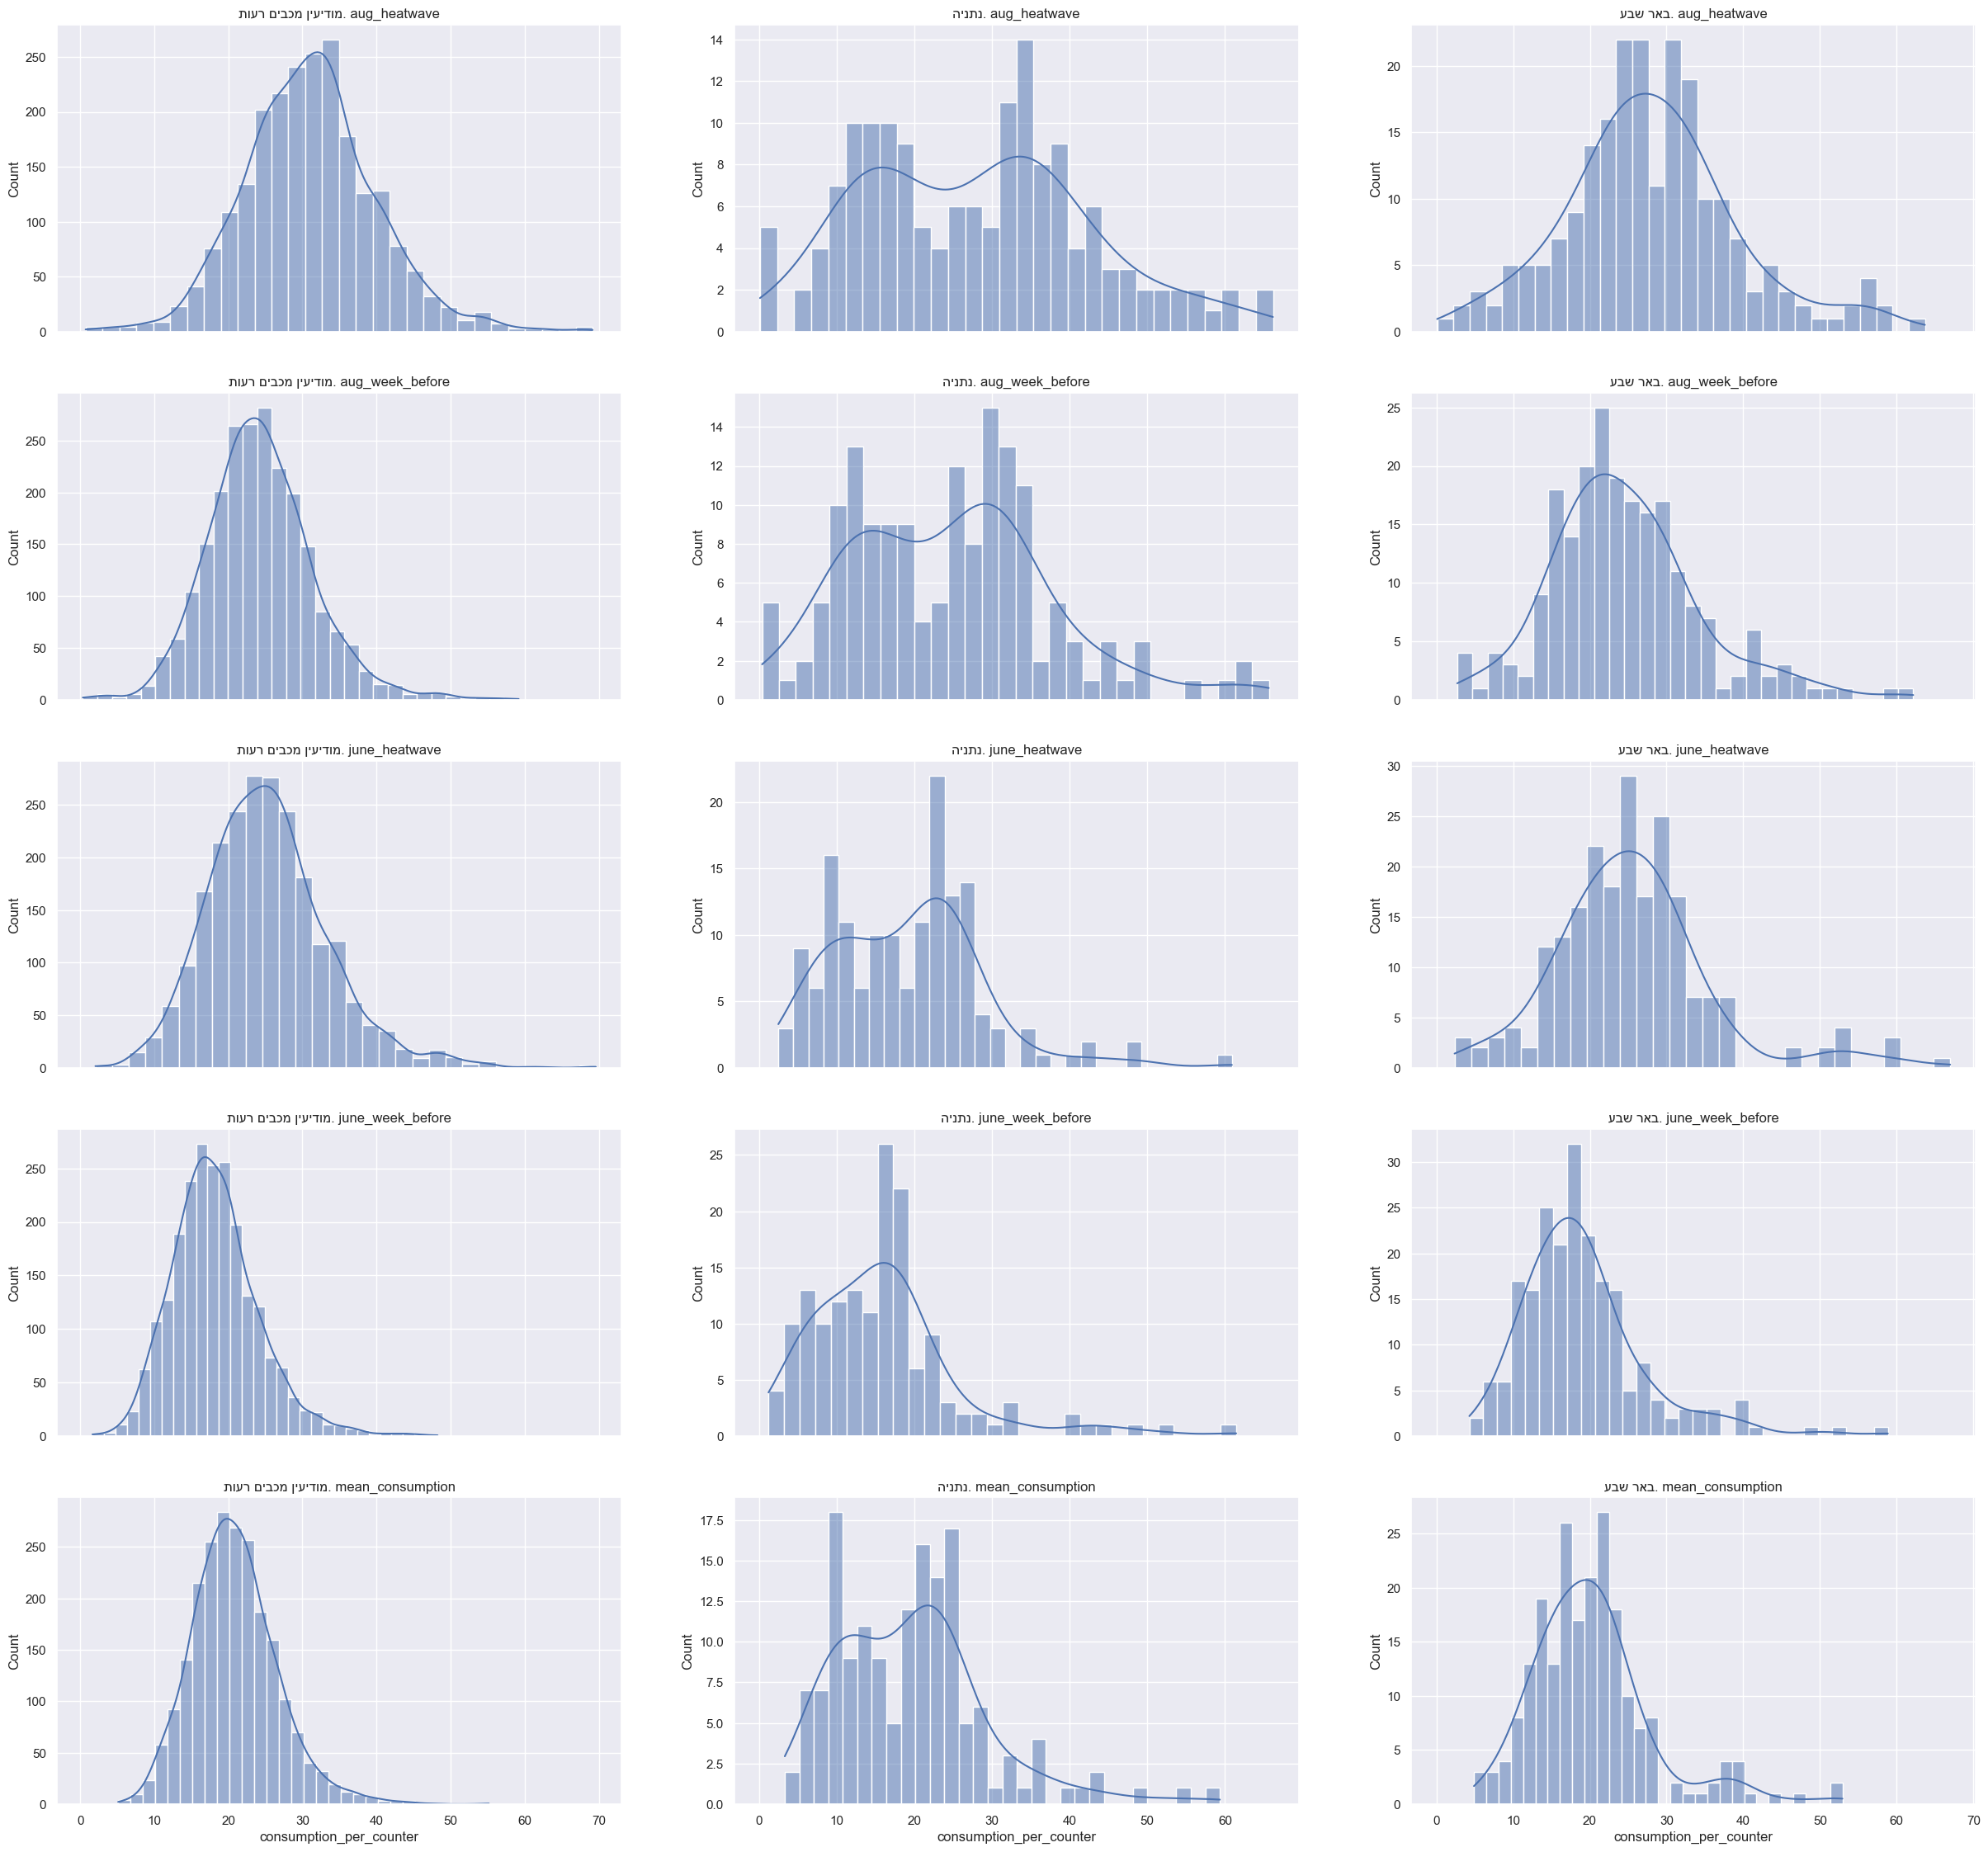

In [69]:
f, ax = plt.subplots(figsize=(30, 28), nrows=5, ncols=3, sharex='col')
for i, city in enumerate([MODIIN, NETANIA, BEERSHEVA]):
    for j, metric in enumerate(sorted(flat_df.consumption_type.unique())):
        f = sns.histplot(data=flat_df[(flat_df.city == city) & (flat_df.consumption_type == metric)], 
                     x='consumption_per_counter', bins=30, kde=True, ax=ax[j][i])
        f.set_title(f'{city[::-1]}. {metric}')
plt.savefig('all')

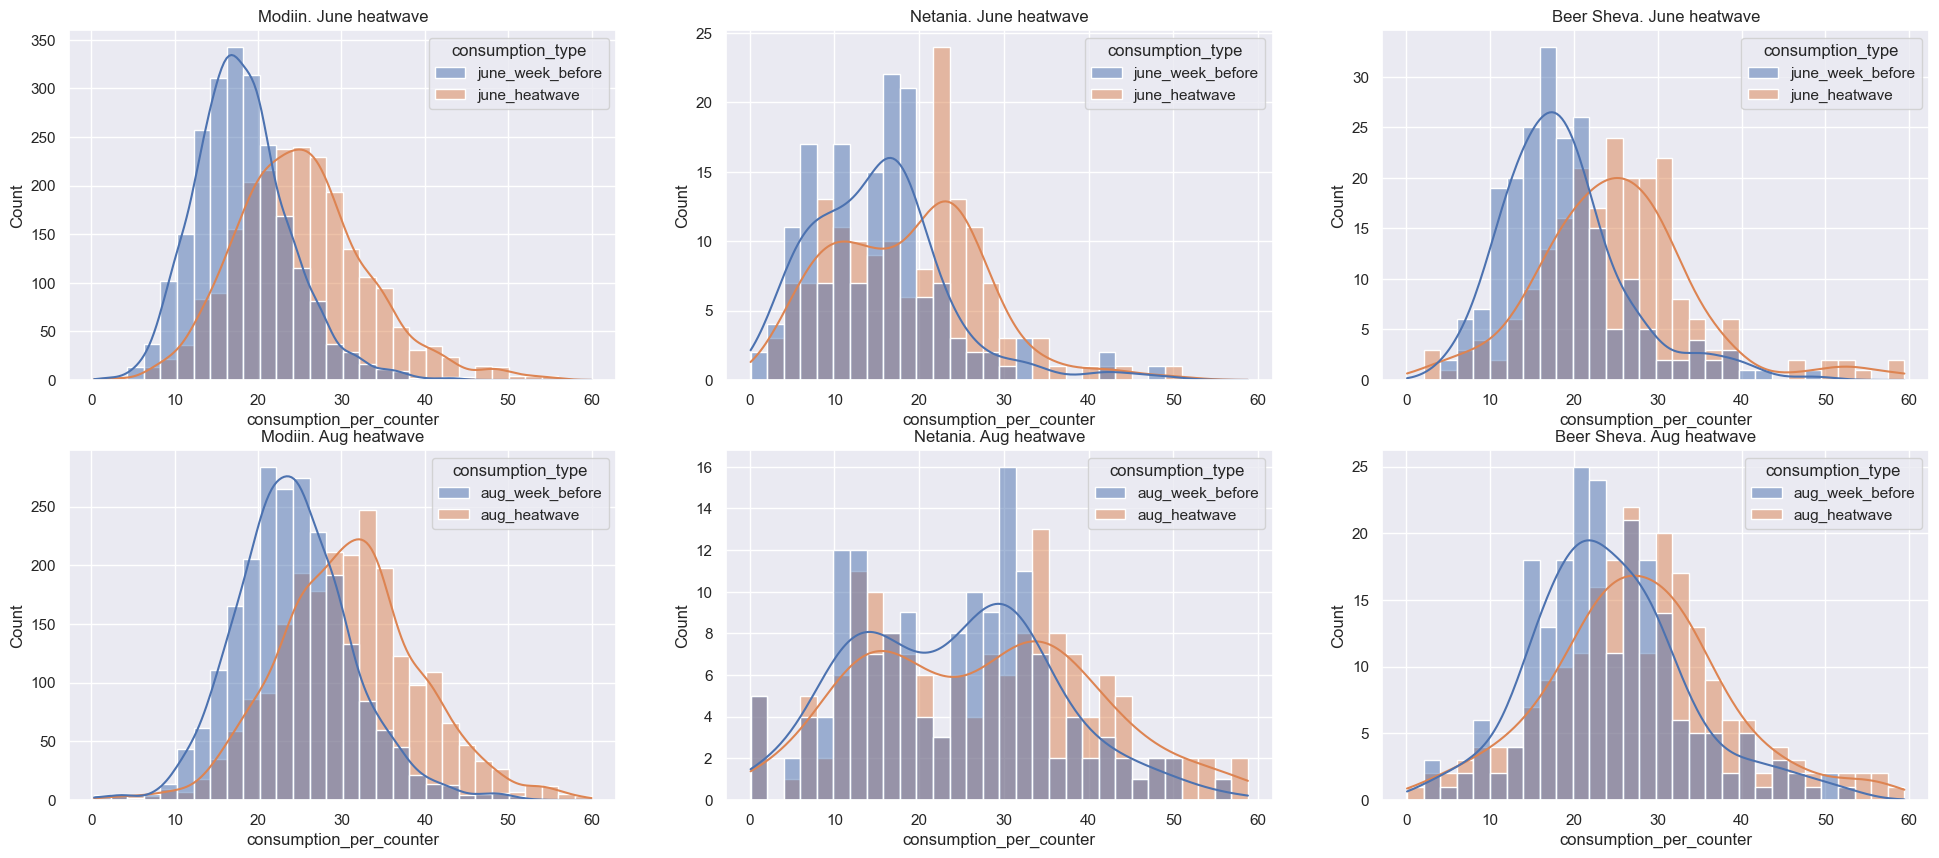

In [30]:
f, ax = plt.subplots(figsize=(24, 10), nrows=2, ncols=3)
f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][0])
f.set_title('Modiin. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][1])
f.set_title('Netania. June heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][2])
f.set_title('Beer Sheva. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][0])
f.set_title('Modiin. Aug heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][1])
f.set_title('Netania. Aug heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][2])
f.set_title('Beer Sheva. Aug heatwave')

plt.savefig('hw_wrt_week_before')

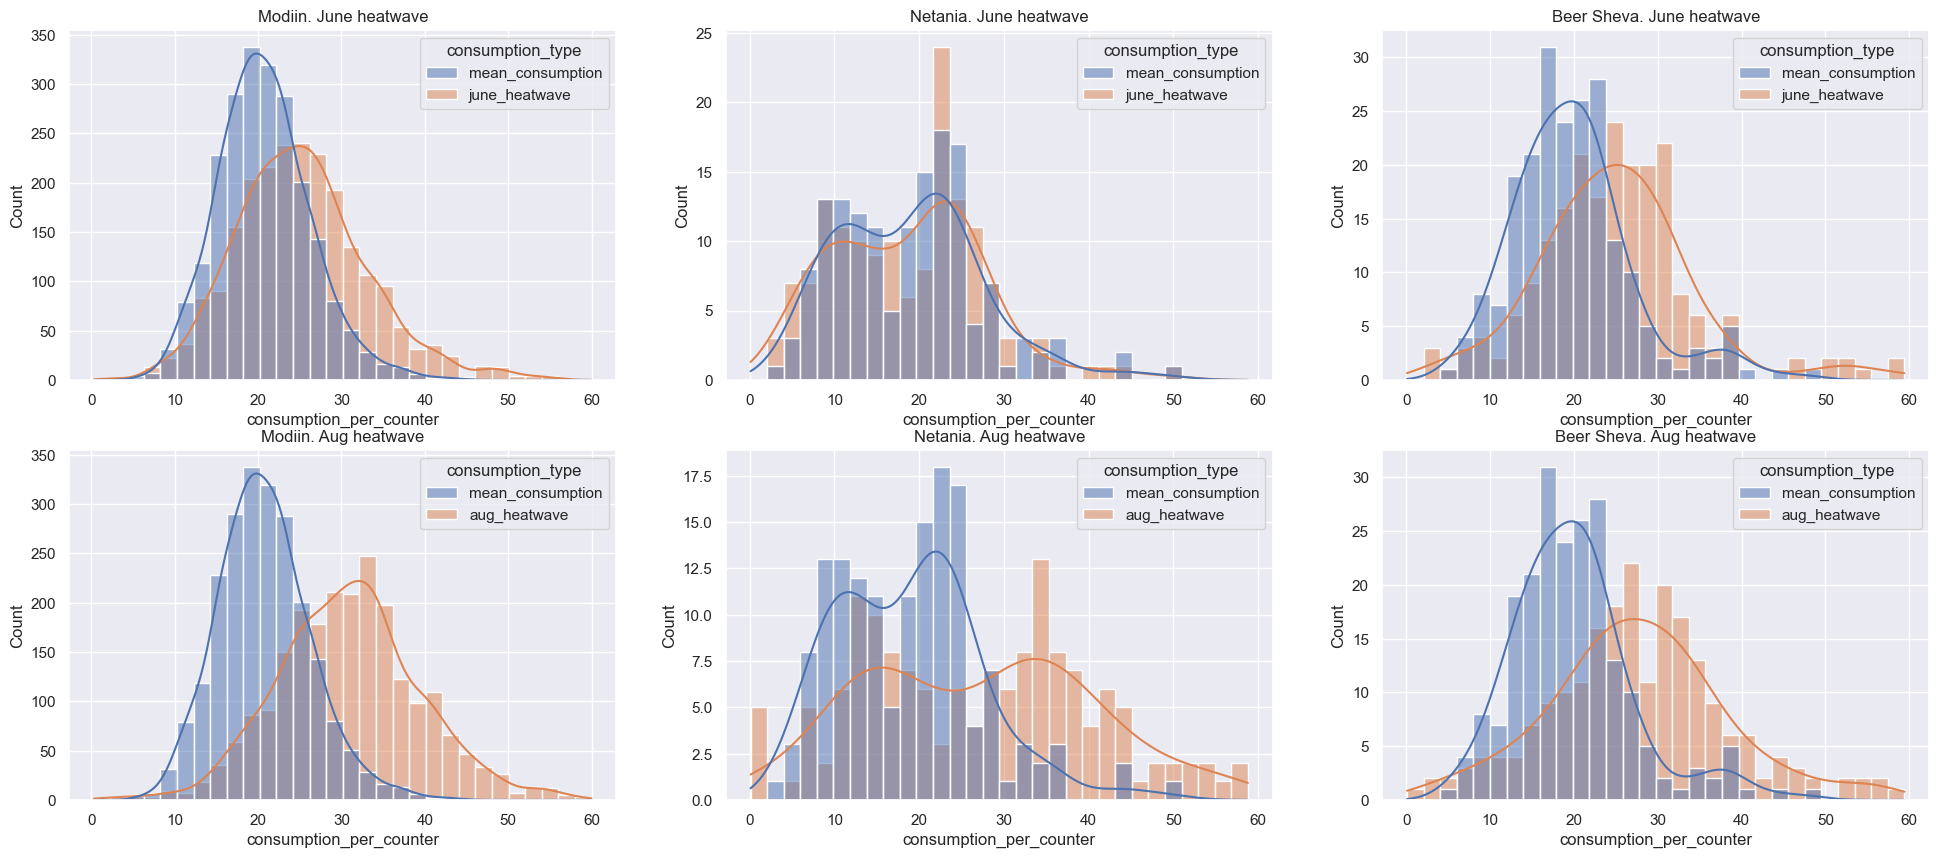

In [31]:
f, ax = plt.subplots(figsize=(24, 10), nrows=2, ncols=3)
f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][0])
f.set_title('Modiin. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][1])
f.set_title('Netania. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][2])
f.set_title('Beer Sheva. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][0])
f.set_title('Modiin. Aug heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][1])
f.set_title('Netania. Aug heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][2])
f.set_title('Beer Sheva. Aug heatwave')

plt.savefig('hw_wrt_avg')

In [63]:
%%time
results = [100*(x[1]/agg_dict[int(x[0])]) for x in h_df[['id', 'consumption']].values]
h_df['normalized_consumption'] = results
h_df.head(1)

CPU times: total: 391 ms
Wall time: 374 ms


id                city         ts  hour  consumption  heat_index  \
230  702552276  מודיעין מכבים רעות 2022-08-21     0        6.263   20.566667   

     count_reg day_type  diff_consumption  normalized_consumption  
230         11  regular        -19.383432               80.616568

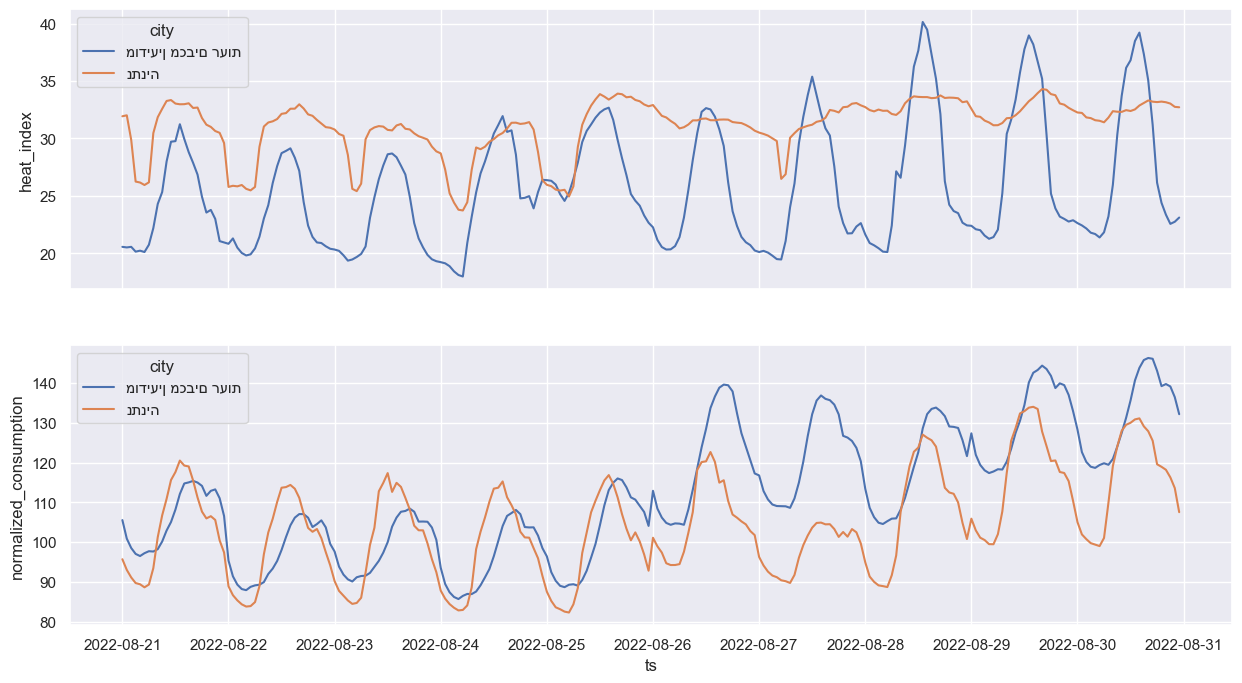

In [74]:
f, ax = plt.subplots(figsize=(15, 8), nrows=2, ncols=1, sharex=True)
sns.lineplot(data=h_df[h_df.ts.dt.day_of_year < doi+3], x='ts', y='heat_index', hue='city', errorbar=None, ax=ax[0])
f = sns.lineplot(data=h_df[h_df.ts.dt.day_of_year < doi+3], x='ts', y='normalized_consumption', hue='city', errorbar=None, ax=ax[1])

In [77]:
gr

hour  consumption  heat_index  count_reg  \
id        ts                                                     
702552276 2022-08-21  11.5     7.060875   24.343290       11.0   
          2022-08-22  11.5     8.100500   23.279549       11.0   
          2022-08-23  11.5     5.560292   22.907526       11.0   
          2022-08-24  11.5    10.440375   24.958951       11.0   
          2022-08-25  11.5     7.682333   27.722616       11.0   
...                    ...          ...         ...        ...   
704550861 2022-08-31  11.5    15.293499   26.406874       13.0   
          2022-09-01  11.5    18.173918   25.430313       13.0   
          2022-09-02  11.5    17.510834   25.017139       13.0   
          2022-09-03  11.5    15.893125   24.881878       13.0   
          2022-09-04  11.5    14.049209   23.975564       13.0   

                      diff_consumption  normalized_consumption  
id        ts                                                    
702552276 2022-08-21         -9.113290               90.886710  
          2022-08-22          4.268637              104.268637  
          2022-08-23        -28.428612               71.571388  
          2022-08-24         34.387216              134.387216  
          2022-08-25         -1.113957               98.886043  
...                                ...                     ...  
704550861 2022-08-31         14.435186              114.435186  
          2022-09-01         35.988204              135.988204  
          2022-09-02         31.026617              131.026617  
          2022-09-03         18.921945              118.921945  
          2022-09-04          5.124651              105.124651  

[33660 rows x 6 columns]

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_1308\1396922553.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr = h_df.groupby([h_df.ts.dt.floor('D'), 'city']).mean().reset_index()


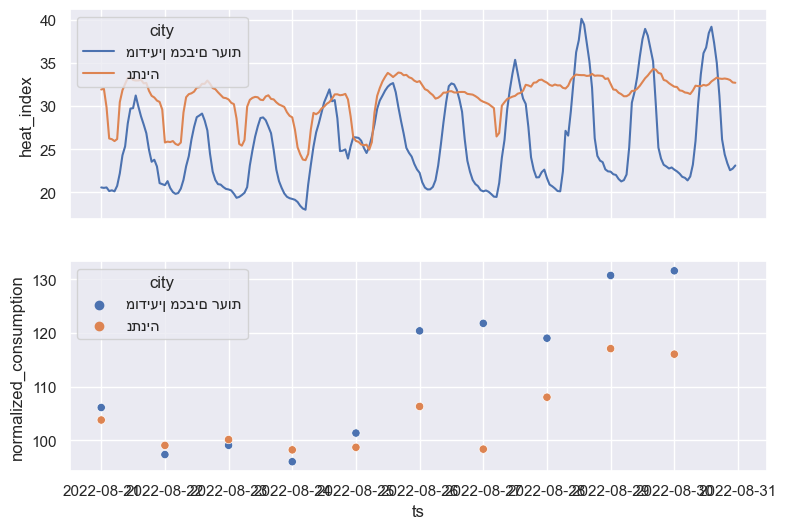

In [85]:
gr = h_df.groupby([h_df.ts.dt.floor('D'), 'city']).mean().reset_index()
f, ax = plt.subplots(figsize=(9, 6), nrows=2, ncols=1, sharex=True)
sns.lineplot(data=h_df[h_df.ts.dt.day_of_year < doi+3], x='ts', y='heat_index', hue='city', ax=ax[0], errorbar=None)
f = sns.scatterplot(data=gr[gr.ts.dt.day_of_year < doi+3], x='ts', y='normalized_consumption', hue='city', ax=ax[1])

# Outliers?

In [ ]:
w_df = pd.read_pickle('weather.pkl').reset_index(drop=True)
w_df = w_df[w_df.ts.dt.year == 2022]
w_df.tail(1)

In [ ]:
HOURS = [10,18]
tmp_df = w_df[(w_df.ts.dt.hour >= HOURS[0]) &(w_df.ts.dt.hour <= HOURS[1])].groupby([w_df.ts.dt.floor('D'), w_df.city]).mean(numeric_only=True).reset_index()
dfs = []
for city in CITIES:
    current = pd.DataFrame(tmp_df[tmp_df.city == city])
    temps = current['heat_index'].values
    for ws in [3,5,7, 10]:
        mean_temps = [temps[0]] + [temps[max(0, i-ws):i].mean() for i in range(1, len(temps))]
        current[f'past_{ws}'] = mean_temps

        mean_temps = [temps[max(0, i-ws):i+ws+1].mean() for i in range(len(temps))]
        current[f'around_{ws}'] = mean_temps
    dfs.append(current)
tmp_df = pd.concat(dfs)
tmp_df.head(5)

In [ ]:
plt.figure(figsize=(20,5))
tmp_df['difference_past_10'] = tmp_df.heat_index - tmp_df.past_10
sns.lineplot(data=tmp_df[(tmp_df.city == MODIIN) & (tmp_df.ts > pd.Timestamp('2022-03-01')) & (tmp_df.ts < pd.Timestamp('2022-10-01'))], x='ts', y='difference_past_10', marker='o')

In [ ]:
THRESHOLD = 2
tmp_df['doy'] = tmp_df.ts.dt.day_of_year
tmp_df['outlier'] = (tmp_df.heat_index - tmp_df.past_10) > THRESHOLD
tmp_df[tmp_df.outlier & (tmp_df.heat_index > 25) & (tmp_df.city == MODIIN)]

In [ ]:
doys = [[85,100],[103, 112], [115, 124], [130,138],[157,167],[212, 220], [235,247],[268,278]]

In [ ]:
city_day_df = day_df[['city', 'ts', 'total', 'day_of_year']].groupby(['city', 'ts']).mean(numeric_only=False).reset_index() 
city_day_df['friday'] = city_day_df.ts.dt.weekday == 4
city_day_df.head(1)

In [ ]:
from matplotlib import pyplot as plt, dates as mdates
_, axis = plt.subplots(figsize=(25, 12), nrows=3, ncols=4)
for i, doy in enumerate(doys[:4]):
    for j, city in enumerate(CITIES):
        ax = sns.lineplot(x='ts', y='temperature', data=tmp_df[(tmp_df.doy >= doy[0])&(tmp_df.doy <= doy[1]) & (tmp_df.city == city)], color="r", ax=axis[j][i])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
        ax.set_title(city[::-1])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax2 = ax.twinx()
        tmp = city_day_df[(city_day_df.day_of_year >= doy[0])&(city_day_df.day_of_year <= doy[1]) & (city_day_df.city == city)]
        places = list(np.where(tmp.friday)[0])
        ax = sns.lineplot(x='ts', y='total', data=tmp, color="b",
                    marker = 'o', markersize=5, fillstyle='none', markeredgewidth=1.5, markeredgecolor='black', markevery=places, ax=ax2)
        
        ax.set_ylabel('')
        
_, axis = plt.subplots(figsize=(25, 12), nrows=3, ncols=4)
for i, doy in enumerate(doys[4:]):
    for j, city in enumerate(CITIES):
        ax = sns.lineplot(x='ts', y='temperature', data=tmp_df[(tmp_df.doy >= doy[0])&(tmp_df.doy <= doy[1]) & (tmp_df.city == city)], color="r", ax=axis[j][i])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
        ax.set_title(city[::-1])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax2 = ax.twinx()
        tmp = city_day_df[(city_day_df.day_of_year >= doy[0])&(city_day_df.day_of_year <= doy[1]) & (city_day_df.city == city)]
        places = list(np.where(tmp.friday)[0])
        ax = sns.lineplot(x='ts', y='total', data=tmp, color="b",
                    marker = 'o', markersize=5, fillstyle='none', markeredgewidth=1.5, markeredgecolor='black', markevery=places, ax=ax2)
        ax.set_ylabel('')
#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))

In [ ]:
from matplotlib import pyplot as plt, dates as mdates
_, axis = plt.subplots(figsize=(8, 35), nrows=7, ncols=1, sharey='row')
for i, doy in enumerate(doys):
    ax = sns.lineplot(x='ts', y='temperature', data=tmp_df[(tmp_df.doy >= doy[0])&(tmp_df.doy <= doy[1])], style='city', color="r", ax=axis[i], style_order=CITIES)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.set_xlabel('')
    ax2 = ax.twinx()
    tmp = city_day_df[(city_day_df.day_of_year >= doy[0])&(city_day_df.day_of_year <= doy[1])]
    places = list(np.where(tmp.friday & (tmp.city == MODIIN))[0])
    sns.lineplot(x='ts', y='total', data=tmp, color="b", style='city', ax=ax2, style_order=CITIES, legend=None)

#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%D'))